In [5]:
from typing import Sequence, Union
import os
import sys
import glob
import itertools
from datetime import datetime
from pprint import pprint
from tqdm import tqdm
import joblib

import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats, linalg
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import torch

import src
from src.attrs import PATHS, GLOBALS
from src import utils

from src.data import loading
from src.train import datasets, losses
from src.models import base, koopman_autoencoder, cnn, cnn3
from src.tools import plot

~/.conda/envs/koopman/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [6]:
plt.style.use('custom.mplstyle')
torch.set_grad_enabled(False)

In [7]:
SUBPROJECT = 'cnn_pacific_daily_subsampled'

In [8]:
checkpoint = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', 'best.ckpt'),
    map_location='cpu'
)
state_dict = checkpoint['state_dict']
B_kae = state_dict['linear_embedding.weight'].numpy()
A_kae = linalg.logm(B_kae)

lim_pca = joblib.load(os.path.join(PATHS[SUBPROJECT], 'lim', 'lim_pca_ssh_d20_best.joblib'))
B_lim_pca = linalg.expm(lim_pca.A)

lim_cae = joblib.load(os.path.join(PATHS[SUBPROJECT], 'lim', 'lim_cae_ssh_d20_best.joblib'))
B_lim_cae = linalg.expm(lim_cae.A)

logm result may be inaccurate, approximate err = 1.7172148685680603e-06


In [9]:
labels = ['KAE', 'PCA', 'CAE']
colors = ['C1', 'C0', 'C3']
kwargs = dict(alpha=0.8, ls='', marker='x')

In [10]:
subprojects = [
    'cnn_pacific_daily_subsampled',
    'cnn_north_atlantic_daily_subsampled',
    'cnn_pacific_monthly',
    'cnn_north_atlantic_monthly'
]
titles = [
    'North Pacific daily',
    'North Atlantic daily',
    'North Pacific monthly',
    'North Atlantic monthly'
]

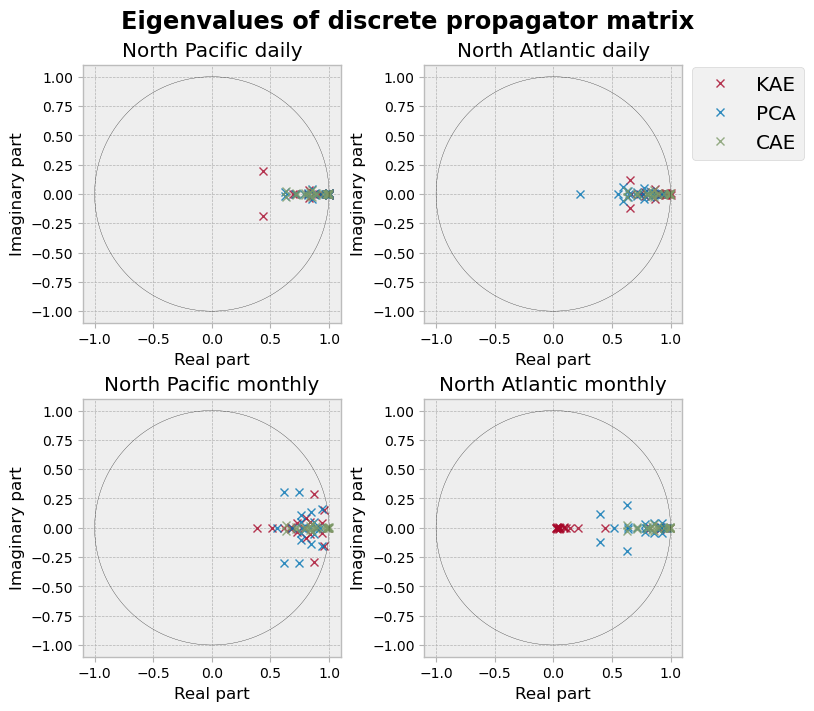

In [11]:
fig, axes = plt.subplot_mosaic(
    [['a', 'b'], ['c', 'd']],
    figsize=(8,7),
    layout='constrained'
)

############################################

for j, (label, subproject) in enumerate(zip(list('abcd'), subprojects)):
    # Load models
    checkpoint = torch.load(
        os.path.join(PATHS['networks'], subproject, 'kae_ssh.20', 'best.ckpt'),
        map_location='cpu'
    )
    state_dict = checkpoint['state_dict']
    lim_pca = joblib.load(os.path.join(PATHS[subproject], 'lim', 'lim_pca_ssh_d20_best.joblib'))
    lim_cae = joblib.load(os.path.join(PATHS[SUBPROJECT], 'lim', 'lim_cae_ssh_d20_best.joblib'))

    B_kae = state_dict['linear_embedding.weight'].numpy()
    B_lim_pca = linalg.expm(lim_pca.A)
    B_lim_cae = linalg.expm(lim_cae.A)

    for i, B in enumerate([B_kae, B_lim_pca, B_lim_cae]):
        eigs = linalg.eig(B)[0]
        axes[label].plot(eigs.real, eigs.imag, color=colors[i], label=labels[i], **kwargs)

    t = np.linspace(0, 2*np.pi, 200)
    axes[label].plot(np.cos(t), np.sin(t), color='k', lw=0.2)
    
    axes[label].set(
        title=titles[j],
        xlim=(-1.1,1.1),
        ylim=(-1.1,1.1),
        xlabel='Real part', 
        ylabel='Imaginary part'
    )
    axes[label].set_aspect('equal')

axes['b'].legend(fontsize='x-large', bbox_to_anchor=(1,1.03))

fig.suptitle("Eigenvalues of discrete propagator matrix")
plt.savefig(os.path.join(PATHS['visualization'], 'Figures', 'eigenvalues.pdf'))

logm result may be inaccurate, approximate err = 1.7172148685680603e-06
logm result may be inaccurate, approximate err = 2.3545718725671533e-06
logm result may be inaccurate, approximate err = 1.1488293468954113e-06
logm result may be inaccurate, approximate err = 8.047464363423334e-07


Text(0.5, 0.98, 'Eigenvalues of evolution matrix')

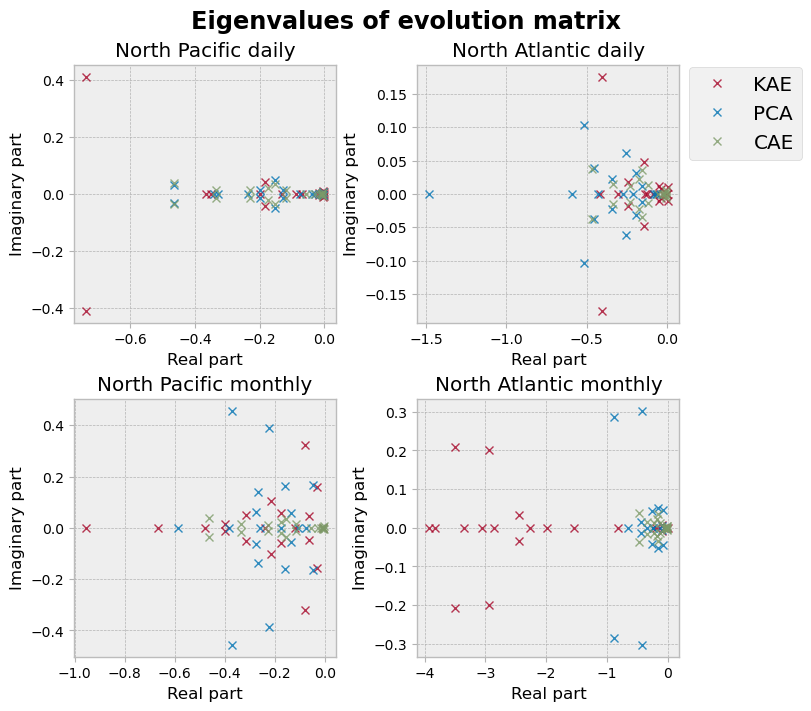

In [14]:
fig, axes = plt.subplot_mosaic(
    [['a', 'b'], ['c', 'd']],
    figsize=(8,7),
    layout='constrained'
)

############################################

for j, (label, subproject) in enumerate(zip(list('abcd'), subprojects)):
    # Load models
    checkpoint = torch.load(
        os.path.join(PATHS['networks'], subproject, 'kae_ssh.20', 'best.ckpt'),
        map_location='cpu'
    )
    state_dict = checkpoint['state_dict']
    lim_pca = joblib.load(os.path.join(PATHS[subproject], 'lim', 'lim_pca_ssh_d20_best.joblib'))
    lim_cae = joblib.load(os.path.join(PATHS[SUBPROJECT], 'lim', 'lim_cae_ssh_d20_best.joblib'))

    B_kae = state_dict['linear_embedding.weight'].numpy()
    A_kae = linalg.logm(B_kae)

    for i, B in enumerate([A_kae, lim_pca.A, lim_cae.A]):
        eigs = linalg.eig(B)[0]
        axes[label].plot(eigs.real, eigs.imag, color=colors[i], label=labels[i], **kwargs)
    
    axes[label].set(
        title=titles[j],
        xlabel='Real part', 
        ylabel='Imaginary part'
    )

axes['b'].legend(fontsize='x-large', bbox_to_anchor=(1,1.03))

fig.suptitle("Eigenvalues of evolution matrix")

## Propagator comparison

In [4]:
# Koopman model
# model = base.load_model_from_yaml(
#     os.path.join(PATHS['cnn_pacific_daily_subsampled'], 'kae', 'koopman_k20_d20')
# )
# SUBPROJECT = 'cnn_pacific_monthly'
SUBPROJECT = 'cnn_north_atlantic_daily_subsampled'
state_dict = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', 'best.ckpt'),
    map_location='cpu'
)['state_dict']
# Propagator matrix
B = state_dict['linear_embedding.weight'].numpy()
# Evolution matrix
A = linalg.logm(B)


logm result may be inaccurate, approximate err = 1.5572131631456756e-06


array([0.4443731 , 0.4482035 , 0.4482035 , 0.52212715, 0.62121   ,
       0.62121   , 0.7505462 , 0.7505462 , 0.762663  , 0.7827244 ,
       0.839443  , 0.90974504, 0.90974504, 0.92790073, 0.92790073,
       0.947019  , 0.99819344, 0.99819344, 1.0097151 , 1.0097151 ],
      dtype=float32)

In [9]:
eigs = linalg.eig(B)[0]
np.sort(eigs.real**2 + eigs.imag**2)

array([0.4443731 , 0.4482035 , 0.4482035 , 0.52212715, 0.62121   ,
       0.62121   , 0.7505462 , 0.7505462 , 0.762663  , 0.7827244 ,
       0.839443  , 0.90974504, 0.90974504, 0.92790073, 0.92790073,
       0.947019  , 0.99819344, 0.99819344, 1.0097151 , 1.0097151 ],
      dtype=float32)

In [8]:
SUBPROJECT = 'cnn_north_atlantic_daily_subsampled'
torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', 'best_pred.ckpt'),
    map_location='cpu'
)['epoch']

190

In [44]:
# Linear inverse model
lim = joblib.load(os.path.join(PATHS['cnn_pacific_daily_subsampled'], 'lim', 'lim_pca_d20_best.joblib'))
lim_A = lim.A
lim_B = linalg.expm(lim.A)

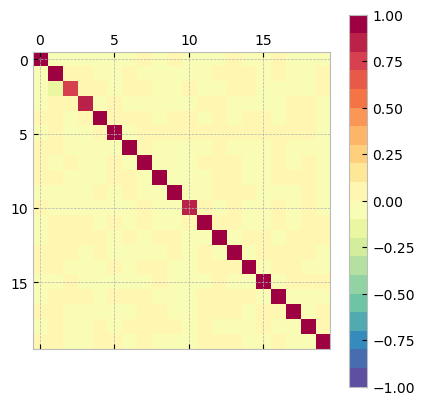

In [45]:
plt.matshow(B, cmap=plt.get_cmap('Spectral_r', 20), vmin=-1, vmax=1)
plt.colorbar()

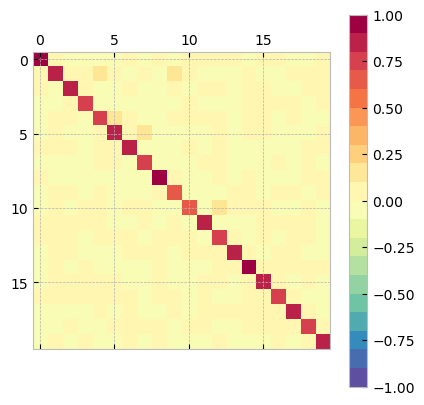

In [46]:
plt.matshow(lim_B, cmap=plt.get_cmap('Spectral_r', 20), vmin=-1, vmax=1)
plt.colorbar()

## Scratch work

In [25]:
SUBPROJECT = 'cnn_pacific_monthly'

In [26]:
checkpoint = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', 'best.ckpt'),
    map_location='cpu'
)
state_dict = checkpoint['state_dict']
B_kae = state_dict['linear_embedding.weight'].numpy()

In [27]:
eigs = linalg.eig(B_kae)[0]
eig_mags = np.sort(eigs.real**2 + eigs.imag**2)
print(eig_mags)

[0.14818585 0.264168   0.38246748 0.45105046 0.45105046 0.5320884
 0.5320884  0.6221199  0.6491761  0.6491761  0.7049987  0.7049987
 0.7883105  0.85064596 0.85064596 0.8840737  0.8840737  0.9380379
 0.9380379  0.9833581 ]


Same thing, but eigenvalues for checkpoint with lower regularization

In [30]:
old_checkpoint = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'old', 'kae_ssh.20', 'best.ckpt'),
    map_location='cpu'
)
old_state_dict = old_checkpoint['state_dict']
old_B_kae = old_state_dict['linear_embedding.weight'].numpy()

In [31]:
old_eigs = linalg.eig(old_B_kae)[0]
old_eig_mags = np.sort(old_eigs.real**2 + old_eigs.imag**2)
print(old_eig_mags)

[0.5703485  0.7346791  0.7441625  0.7441625  0.77298415 0.77298415
 0.80942017 0.82034636 0.82034636 0.86399925 0.8780408  0.8780408
 0.97204435 0.97204435 1.0018792  1.0018792  1.004357   1.004357
 1.0523375  1.0523375 ]


So it seems like regularization has helped reduce the eigenvalues to be less than 1.

Verify the same thing for 

In [34]:
SUBPROJECT = 'cnn_north_atlantic_monthly'

In [35]:
checkpoint = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', 'best.ckpt'),
    map_location='cpu'
)
state_dict = checkpoint['state_dict']
B_kae = state_dict['linear_embedding.weight'].numpy()

In [36]:
eigs = linalg.eig(B_kae)[0]
eig_mags = np.sort(eigs.real**2 + eigs.imag**2)
print(eig_mags)

[3.9066534e-04 4.7693201e-04 9.2432520e-04 9.2432520e-04 1.2347099e-03
 2.2122331e-03 2.8082696e-03 2.8082696e-03 3.3470488e-03 7.6042283e-03
 7.6042283e-03 1.0869414e-02 1.9177860e-02 4.5686625e-02 1.9636847e-01
 6.7556316e-01 8.3280301e-01 8.3280301e-01 9.0183151e-01 9.9754208e-01]


Same thing, but eigenvalues for checkpoint with lower regularization

In [37]:
old_checkpoint = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'old', 'kae_ssh.20', 'best.ckpt'),
    map_location='cpu'
)
old_state_dict = old_checkpoint['state_dict']
old_B_kae = old_state_dict['linear_embedding.weight'].numpy()

In [38]:
old_eigs = linalg.eig(old_B_kae)[0]
old_eig_mags = np.sort(old_eigs.real**2 + old_eigs.imag**2)
print(old_eig_mags)

[0.52827746 0.52827746 0.6835776  0.77239037 0.77239037 0.82045555
 0.82045555 0.83144873 0.83144873 0.8577338  0.90386444 0.90386444
 0.9322625  0.9322625  0.9533534  0.9533534  1.0029582  1.0029582
 1.0372994  1.0372994 ]
